<a href="https://colab.research.google.com/github/blockmoo/Python/blob/main/cv_stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **구글 드라이브 마운트**

In [ ]:
# 구드 마운트 
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# #  **새로운 방법**




In [ ]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
# 사용할 패키지들을 불러와서 포함시키는 코드이다.
# python package들을 가져오는 것과 matplotlib 출력 옵션 설정에 대한 내용이다.
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

# **데이터 불러오기**

In [ ]:
import pandas as pd

os.chdir('/content/drive/MyDrive/응통_통계연구논문')
X_train = pd.read_csv("./train_x.csv")
X_test = pd.read_csv("./test_x.csv")
y_train = pd.read_csv("./train_y.csv")
y_test = pd.read_csv("./test_y.csv")
# train 데이터 살펴보기
X_test.describe(include="all")


,temp,atemp,humidity,windspeed,casual,registered,month,hour,season,holiday,workingday,weather,year2011,year2012,weekday5,weekday4,weekday3,weekday1,weekday7,weekday6,weekday2
count,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000
mean,20.388022,23.842754,62.086038,12.764542,37.413962,154.315677,6.568585,11.447336,2.526944,0.031231,0.673913,1.417330,0.490508,0.509492,0.140539,0.140845,0.139008,0.142070,0.144519,0.150337,0.142682
std,7.882911,8.575272,19.162358,8.146262,52.062244,149.029156,3.422614,6.938969,1.104928,0.173968,0.468851,0.636361,0.499986,0.499986,0.347598,0.347915,0.346008,0.349175,0.351669,0.357456,0.349802
min,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.940000,16.665000,47.000000,7.001500,4.000000,37.000000,4.000000,6.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.500000,24.240000,62.000000,12.998000,17.000000,118.000000,7.000000,12.000000,3.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,27.060000,31.060000,77.000000,16.997900,51.750000,223.000000,9.000000,17.000000,3.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,39.360000,45.455000,100.000000,56.996900,367.000000,886.000000,12.000000,23.000000,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# pd dataframe을 numpy 배열로 변환
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# 범주형변수 / 수치형변수 나누기

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


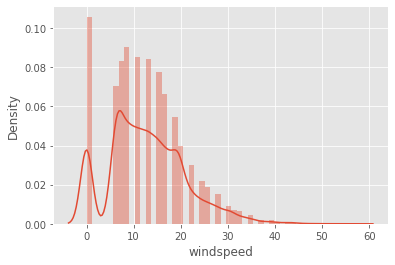

In [ ]:
sns.distplot(all['windspeed']);










# **Classification cv_stacking**


In [ ]:
############ classification
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

svm = SVC()
rf = RandomForestClassifier()
logis = LogisticRegression()
nnet = MLPClassifier()

## classification dataset
os.chdir("/content/drive/MyDrive/응통_통계연구논문")

In [ ]:
def get_stacking_dat(model, X_train, y_train, X_test, n_folds):
  kfold = KFold(n_splits = n_folds, random_state = 0, shuffle=False)

  #최종 모델에서 사용할 데이터셋 셋팅(0 값으로)
  #만약 shape가 (100,10) 이었으면 폴드의 검증 과정에서 저장할 데이터는 (100,1) 모양을 갖게 한다.
  train_fold_predict = np.zeros((X_train.shape[0],1))   # 2차원으로 
  # test는 X_test 값을 이용해서 매 폴드마다 예측을 하기 때문에 (100, fold개수) 만큼의 shape를 각제 된다.
  # 그래서 해당 폴드마다 X_test의 예측 값을 해당 fold에 해당되는 열에 넣는다.
  test_predict = np.zeros((X_test.shape[0], n_folds))
  print("model : ", model.__class__.__name__)

  for cnt, (train_index, valid_index) in enumerate(kfold.split(X_train)):
    print(f" Fold 횟수 : {cnt+1}")
    X_train_ = X_train[train_index]
    y_train_ = y_train[train_index]
    X_validation = X_train[valid_index]

    #학습 (개별 모델이 학습한 후 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가)
    model.fit(X_train_, y_train_)

    #해당 폴드에서 학습된 모델에다가 검증 데이터(X_validation)로 예측 후 저장
    train_fold_predict[valid_index, :] = model.predict(X_validation).reshape(-1,1)

    #해당 폴드에서 생성된 모델에 원본 테스트 데이터(X_test)를 이용해서 예측 후 최종 메타모델이 검증할 데이터셋에 저장
    test_predict[:, cnt] = model.predict(X_test)

  #for문이 끝나면 test_predict는 평균을 내서 하나로 합친다.
  # 개별모델안에서 테스트 데이터셋을 기반으로 예측한 결과값들을 mean 취해주고 2차원으로 바꾸어주기
  test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)

  return train_fold_predict, test_predict_mean


In [ ]:
svm_train, svm_test = get_stacking_dat(svm, X_train, y_train, X_test, n_folds = 5)
rf_train, rf_test = get_stacking_dat(rf, X_train, y_train, X_test, n_folds = 5)
nnet_train, nnet_test = get_stacking_dat(nnet, X_train, y_train, X_test, n_folds = 5)

In [ ]:
# 개별모델이 생성한 학습/검증 데이터 최종 메타 모델이 학습/검증하도록 결합
new_X_train = np.concatenate((svm_train, rf_train, nnet_train), axis = 1)
new_X_test = np.concatenate((svm_test, rf_test, nnet_test), axis = 1)

In [ ]:
print("원본 : ", X_train.shape, X_test.shape)
print("새로운 : ", new_X_train.shape, new_X_test.shape)

원본 :  (21000, 35) (9000, 35)
새로운 :  (21000, 3) (9000, 3)


In [ ]:
#최종 메타모델로 학습
#최종 메타모델 학습시 label은 원본데이터의 label(y값)
logis.fit(new_X_train, y_train)
stack_pred = logis.predict(new_X_test)

#최종 메타모델 성능 평가(비교할 때 원본 데이터의 검증 데이터 label과 비교)
print(f"최종 메타모델 정확도 : {accuracy_score(stack_pred, y_test):.4f}")

# **모델 성능을 나타내는 함수 get_accuracy : (accuracy)**

In [ ]:
##### 모델 성능을 나타내는 함수 (accuracy)
def get_accuracy(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  model.pred = model.predict(X_test)
  print("최종 메타모델 정확도 : {0:.4f}".format(accuracy_score(model.pred, y_test)))
  print(model.pred)

In [ ]:
print(get_accuracy(svm, X_train, y_train, X_test, y_test))
print(get_accuracy(rf, X_train, y_train, X_test, y_test))
print(get_accuracy(nnet, X_train, y_train, X_test, y_test))
print(get_accuracy(logis, new_X_train, y_train, new_X_test, y_test))

# **Regression cv-stacking**

In [ ]:
##### Regression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# 생성된 회귀분석모델에 대한 결정계수 MSE, RMSE를 구해보자. 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

svm = SVR()
rf = RandomForestRegressor()
lr = LinearRegression()
logis = LogisticRegression()
nnet = MLPRegressor()

In [ ]:
svm_train, svm_test = get_stacking_dat(svm, X_train, y_train, X_test, n_folds = 10)
rf_train, rf_test = get_stacking_dat(rf, X_train, y_train, X_test, n_folds = 10)
nnet_train, nnet_test = get_stacking_dat(nnet, X_train, y_train, X_test, n_folds = 10)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model :  SVR
 Fold 횟수 : 1
 Fold 횟수 : 2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 6


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 7


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 10


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


model :  RandomForestRegressor
 Fold 횟수 : 1
 Fold 횟수 : 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fold 횟수 : 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fold 횟수 : 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fold 횟수 : 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fold 횟수 : 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fold 횟수 : 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fold 횟수 : 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fold 횟수 : 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fold 횟수 : 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model :  MLPRegressor
 Fold 횟수 : 1
 Fold 횟수 : 2


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 3
 Fold 횟수 : 4


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 5


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 6
 Fold 횟수 : 7


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 8
 Fold 횟수 : 9


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Fold 횟수 : 10


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## **gridsearch 작업 코드**  (일단 보류)

In [ ]:
# # rmsle
# def rmsle(y, y_,convertExp=True):
#     if convertExp:
#         y = np.exp(y),
#         y_ = np.exp(y_)
#     log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
#     log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
#     calc = (log1 - log2) ** 2
#     return np.sqrt(np.mean(calc))

In [ ]:
# #You can do grid search in SVM
# scorer = make_scorer(rmsle, greater_is_better=False)
# params = {'coef0':[0, 0.1, 0.5, 1], 'C' :[0.1, 0.5, 1], 'epsilon':[0.1, 0.3, 0.5]}

# grid_search = GridSearchCV(svm, params, cv=5, scoring=scorer)
# grid_search.fit(X_train, y_train)

In [ ]:
# grid_search.best_estimator_

In [ ]:
#You can do grid search in RandomForest

# param_grid = [
#    {'n_estimators': [3, 10, 30, 60, 90], 'max_features': [10,20,30,40,50]},
#    {'bootstrap': [True], 'n_estimators': [3, 10, 30, 60, 90], 'max_features': [10,20,30,40,50]},
# ]

# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=scorer)
# grid_search.fit(X_train, y_train)

In [ ]:
# grid_search.best_estimator_

In [ ]:
new_X_train = np.concatenate((svm_train, rf_train, nnet_train), axis = 1)
new_X_test = np.concatenate((svm_test, rf_test, nnet_test), axis = 1)
print("원본 : ", X_train.shape, X_test.shape)
print("새로운 : ", new_X_train.shape, new_X_test.shape)


원본 :  (7620, 21) (3266, 21)
새로운 :  (7620, 3) (3266, 3)


In [ ]:
lr.fit(new_X_train, y_train)
stack_pred = lr.predict(new_X_test)


# **모델성능을 나타내는 함수 get_mse  : (score, MSE, RMSE)**




In [ ]:
##### 모델 성능을 나타내는 함수 (score, MSE, RMSE)
def get_mse(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  model_pred = model.predict(X_test)

  # 적합도 검증 - 잔차
  residuals = y_test-model_pred

  # 적합도 검증 - 결정계수
  SSE = (residuals**2).sum()
  SST = ((y_test-y_test.mean())**2).sum()
  R_squared = 1 - (SSE/SST)
  print('R_squared = ', R_squared)

  # 생성된 회귀분석모델에 대한 결정계수, MSE, RMSE를 구해보자. 
  print('score = ', model.score(X = X_train, y=y_train))
  print('Mean_Squared_Error = ', mean_squared_error(model_pred, y_test))
  print('RMSE = ', mean_squared_error(model_pred, y_test)**0.5)



In [ ]:
#print(get_mse(svm, X_train, y_train, X_test, y_test))
#print(get_mse(rf, X_train, y_train, X_test, y_test))
#print(get_mse(nnet, X_train, y_train, X_test, y_test))
print(get_mse(lr, new_X_train, y_train, new_X_test, y_test))

R_squared =  0.999999761681031
score =  0.9999982080320119
Mean_Squared_Error =  0.007814193555759992
RMSE =  0.08839792732728519
None


**cv를 적용한 개별 모델들의 성능**

In [ ]:
X_train_all = np.concatenate((X_train, X_test),axis=0)
y_train_all = np.concatenate((y_train, y_test),axis=None)
X_train_all.shape

(10886, 21)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm, X_train_all, y_train_all, scoring="r2", cv=5)
print(scores)
print("교차 검증 평균 점수: {:.2f}".format(scores.mean()))


[0.96297784 0.96747531 0.9698155  0.98154234 0.94136347]
교차 검증 평균 점수: 0.96


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train_all, y_train_all, scoring="r2", cv=5)
print(scores)
print("교차 검증 평균 점수: {:.2f}".format(scores.mean()))


[0.99976357 0.99975164 0.99979226 0.99959803 0.99956359]
교차 검증 평균 점수: 1.00


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nnet, X_train_all, y_train_all, scoring="r2", cv=5)
print(scores)
print("교차 검증 평균 점수: {:.2f}".format(scores.mean()))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.99999827 0.99999869 0.99999867 0.99999809 0.99999844]
교차 검증 평균 점수: 1.00
